# Evaluation Notebook - LC-PFN vs. Parametric Models
### Comparative experiment: UD, UL, UDUL

In [1]:
import os
from concurrent.futures import ThreadPoolExecutor, as_completed
import multiprocessing as mp
from functools import partial

os.environ['OMP_NUM_THREADS'] = '8'
os.environ['MKL_NUM_THREADS'] = '8'
os.environ['NUMBA_NUM_THREADS'] = '8'

import h5py
import numpy as np
import torch
torch.set_num_threads(4)
import random
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import pandas as pd
import seaborn as sns
from scipy import stats
import itertools
from scipy.optimize import curve_fit
from sklearn.model_selection import train_test_split
from pathlib import Path
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

import lcpfn
from lcpfn import bar_distribution, encoders, train, utils

In [2]:
### hyperparameter
OPENML_ID = {0: '3', 1: '6', 2: '11', 3: '12', 4: '13', 5: '14', 6: '15', 7: '16', 8: '18', 9: '21', 10: '22', 11: '23', 12: '24', 13: '26', 14: '28', 15: '29', 16: '30', 17: '31', 18: '32', 19: '36', 20: '37', 21: '38', 22: '44', 23: '46', 24: '50', 25: '54', 26: '55', 27: '57', 28: '60', 29: '61', 30: '151', 31: '179', 32: '180', 33: '181', 34: '182', 35: '184', 36: '185', 37: '188', 38: '201', 39: '273', 40: '293', 41: '299', 42: '300', 43: '307', 44: '336', 45: '346', 46: '351', 47: '354', 48: '357', 49: '380', 50: '389', 51: '390', 52: '391', 53: '392', 54: '393', 55: '395', 56: '396', 57: '398', 58: '399', 59: '401', 60: '446', 61: '458', 62: '469', 63: '554', 64: '679', 65: '715', 66: '718', 67: '720', 68: '722', 69: '723', 70: '727', 71: '728', 72: '734', 73: '735', 74: '737', 75: '740', 76: '741', 77: '743', 78: '751', 79: '752', 80: '761', 81: '772', 82: '797', 83: '799', 84: '803', 85: '806', 86: '807', 87: '813', 88: '816', 89: '819', 90: '821', 91: '822', 92: '823', 93: '833', 94: '837', 95: '843', 96: '845', 97: '846', 98: '847', 99: '849', 100: '866', 101: '871', 102: '881', 103: '897', 104: '901', 105: '903', 106: '904', 107: '910', 108: '912', 109: '913', 110: '914', 111: '917', 112: '923', 113: '930', 114: '934', 115: '953', 116: '958', 117: '959', 118: '962', 119: '966', 120: '971', 121: '976', 122: '977', 123: '978', 124: '979', 125: '980', 126: '991', 127: '993', 128: '995', 129: '1000', 130: '1002', 131: '1018', 132: '1019', 133: '1020', 134: '1021', 135: '1036', 136: '1040', 137: '1041', 138: '1042', 139: '1049', 140: '1050', 141: '1053', 142: '1056', 143: '1063', 144: '1067', 145: '1068', 146: '1069', 147: '1083', 148: '1084', 149: '1085', 150: '1086', 151: '1087', 152: '1088', 153: '1116', 154: '1119', 155: '1120', 156: '1128', 157: '1130', 158: '1134', 159: '1138', 160: '1139', 161: '1142', 162: '1146', 163: '1161', 164: '1166', 165: '1216', 166: '1233', 167: '1235', 168: '1236', 169: '1441', 170: '1448', 171: '1450', 172: '1457', 173: '1461', 174: '1462', 175: '1464', 176: '1465', 177: '1468', 178: '1475', 179: '1477', 180: '1478', 181: '1479', 182: '1480', 183: '1483', 184: '1485', 185: '1486', 186: '1487', 187: '1488', 188: '1489', 189: '1494', 190: '1497', 191: '1499', 192: '1501', 193: '1503', 194: '1509', 195: '1510', 196: '1515', 197: '1566', 198: '1567', 199: '1575', 200: '1590', 201: '1592', 202: '1597', 203: '4134', 204: '4135', 205: '4137', 206: '4534', 207: '4538', 208: '4541', 209: '6332', 210: '23381', 211: '23512', 212: '23517', 213: '40498', 214: '40499', 215: '40664', 216: '40668', 217: '40670', 218: '40672', 219: '40677', 220: '40685', 221: '40687', 222: '40701', 223: '40713', 224: '40900', 225: '40910', 226: '40923', 227: '40927', 228: '40966', 229: '40971', 230: '40975', 231: '40978', 232: '40979', 233: '40981', 234: '40982', 235: '40983', 236: '40984', 237: '40994', 238: '40996', 239: '41027', 240: '41142', 241: '41143', 242: '41144', 243: '41145', 244: '41146', 245: '41150', 246: '41156', 247: '41157', 248: '41158', 249: '41159', 250: '41161', 251: '41163', 252: '41164', 253: '41165', 254: '41166', 255: '41167', 256: '41168', 257: '41169', 258: '41228', 259: '41972', 260: '42734', 261: '42742', 262: '42769', 263: '42809', 264: '42810'}
LEARNER_ZOO = {0: 'SVC_linear', 1: 'SVC_poly', 2: 'SVC_rbf', 3: 'SVC_sigmoid', 4: 'Decision Tree', 5: 'ExtraTree', 6: 'LogisticRegression', 7: 'PassiveAggressive', 8: 'Perceptron', 9: 'RidgeClassifier', 10: 'SGDClassifier', 11: 'MLP', 12: 'LDA', 13: 'QDA', 14: 'BernoulliNB', 15: 'MultinomialNB', 16: 'ComplementNB', 17: 'GaussianNB', 18: 'KNN', 19: 'NearestCentroid', 20: 'ens.ExtraTrees', 21: 'ens.RandomForest', 22: 'ens.GradientBoosting', 23: 'DummyClassifier'}
ANCHOR_SIZE = np.ceil(16 * 2 ** ((np.arange(137)) / 8)).astype(int)

### load data: validation accuracy
lc_data = h5py.File(Path.cwd() / '../LCDB11_ACC_265_noFS_raw_compress.hdf5', 'r')['accuracy'][...][:,:,:,:,:,1]

mean_valid_lc_nofs =np.nanmean(lc_data, axis=(2, 3))

In [3]:
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.cuda.manual_seed(SEED)
torch.manual_seed(SEED)

### dataset split
train_data_indices, test_data_indices = train_test_split(np.arange(len(OPENML_ID)), test_size=0.2, random_state=42)

### learner split
train_learner_indices, test_learner_indices = train_test_split(np.arange(len(LEARNER_ZOO)), test_size=0.2, random_state=42)

### UD, UL, UDUL
train_data = lc_data[train_data_indices][:, train_learner_indices, :].transpose(0, 2, 3, 1, 4).reshape(-1, 1, 137)
test_data_KDKL = lc_data[train_data_indices][:, train_learner_indices, :].transpose(0, 2, 3, 1, 4).reshape(-1, 1, 137)
test_data_UD = lc_data[test_data_indices][:, train_learner_indices, :].transpose(0, 2, 3, 1, 4).reshape(-1, 1, 137)
test_data_UL = lc_data[train_data_indices][:, test_learner_indices, :].transpose(0, 2, 3, 1, 4).reshape(-1, 1, 137)
test_data_UDUL = lc_data[test_data_indices][:, test_learner_indices, :].transpose(0, 2, 3, 1, 4).reshape(-1, 1, 137)

print(f"Train data shape: {train_data.shape}")
print(f"Test data KDKL shape: {test_data_KDKL.shape}")
print(f"Test data UD shape: {test_data_UD.shape}")
print(f"Test data UL shape: {test_data_UL.shape}")
print(f"Test data UDUL shape: {test_data_UDUL.shape}")

test_KDKL_curves = []
test_KDKL_curve_lengths = []

for i in range(test_data_KDKL.shape[0]):
    curve = test_data_KDKL[i, 0, :]
    curve_length = np.count_nonzero(~np.isnan(curve))

    if curve_length == 80:
        test_KDKL_curves.append(curve)
        test_KDKL_curve_lengths.append(curve_length)

print(f"KDKL Testing set size: {len(test_KDKL_curves)} curves")

test_UL_curves = []
test_UL_curve_lengths = []

for i in range(test_data_UL.shape[0]):
    curve = test_data_UL[i, 0, :]
    curve_length = np.count_nonzero(~np.isnan(curve))

    if curve_length > 0:
        test_UL_curves.append(curve)
        test_UL_curve_lengths.append(curve_length)

print(f"UL Testing set size: {len(test_UL_curves)} curves")

test_UD_curves = []
test_UD_curve_lengths = []

for i in range(test_data_UD.shape[0]):
    curve = test_data_UD[i, 0, :]
    curve_length = np.count_nonzero(~np.isnan(curve))

    if curve_length > 0:
        test_UD_curves.append(curve)
        test_UD_curve_lengths.append(curve_length)

print(f"UD Testing set size: {len(test_UD_curves)} curves")

test_UDUL_curves = []
test_UDUL_curve_lengths = []

for i in range(test_data_UDUL.shape[0]):
    curve = test_data_UDUL[i, 0, :]
    curve_length = np.count_nonzero(~np.isnan(curve))

    if curve_length > 0:
        test_UDUL_curves.append(curve)
        test_UDUL_curve_lengths.append(curve_length)

print(f"UDUL Testing set size: {len(test_UDUL_curves)} curves")

Train data shape: (100700, 1, 137)
Test data KDKL shape: (100700, 1, 137)
Test data UD shape: (25175, 1, 137)
Test data UL shape: (26500, 1, 137)
Test data UDUL shape: (6625, 1, 137)
KDKL Testing set size: 2239 curves
UL Testing set size: 24761 curves
UD Testing set size: 24725 curves
UDUL Testing set size: 6175 curves


Import trained model.

In [4]:
model_name = 'lcpfn_model_exp1_140_512_12_1000_0.0001_100_1000.pth'
model = torch.load(f'../trained_models/{model_name}', weights_only=False)
model.eval()

TransformerModel(
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-11): 12 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_features=512, bias=True)
        )
        (linear1): Linear(in_features=512, out_features=1024, bias=True)
        (dropout): Dropout(p=0.2, inplace=False)
        (linear2): Linear(in_features=1024, out_features=512, bias=True)
        (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.2, inplace=False)
        (dropout2): Dropout(p=0.2, inplace=False)
      )
    )
  )
  (encoder): Sequential(
    (0): Normalize()
    (1): Normalize()
    (2): Linear(in_features=1, out_features=512, bias=True)
  )
  (y_encoder): Sequential(
    (0): Normalize()
    (1): Linear(in_features=1, out_features=512, bias=True)
  )
  (pos_encoder): N

## Extrapolating curves

In [5]:
def extrapolate_lcpfn(curve, anchor_sizes, model, min_points=10, qs=[0.05, 0.5, 0.95],
                     random_cutoff=True, fixed_cutoff_idx=None, cutoff_percentage=None):
    """
    Extrapolate a learning curve using the LC-PFN model.

    Args:
        curve: Original learning curve (1D array)
        anchor_sizes: Training sizes corresponding to the curve points
        model: Trained LC-PFN model
        min_points: Minimum number of points to use for fitting
        qs: Quantiles for prediction intervals
        random_cutoff: If True, uses a random cutoff point
        fixed_cutoff_idx: If provided, uses this specific cutoff index instead of generating a random one
        cutoff_percentage: If provided, uses this percentage of the curve for training (e.g., 0.7 for 70%)

    Returns:
        x_train: Training x values (indices)
        y_train_norm: Normalised training y values
        x_test: Test x values (indices)
        y_test: Test y values (ground truth)
        pred_mean: Predicted mean values
        pred_lower: Lower prediction interval
        pred_upper: Upper prediction interval
    """

    valid_mask = np.isfinite(curve)
    valid_curve = curve[valid_mask]
    valid_anchors = anchor_sizes[:len(curve)][valid_mask]

    if len(valid_curve) <= min_points:
        return None, None, None, None, None, None, None

    y = torch.from_numpy(valid_curve).float().unsqueeze(-1)
    x = torch.arange(1, y.shape[0] + 1).unsqueeze(-1).float()

    if cutoff_percentage is not None:
        cutoff_idx = max(min_points, int(cutoff_percentage * len(valid_curve)))
        cutoff_idx = min(cutoff_idx, len(valid_curve) - 1)  # Ensure we have at least 1 test point
    elif fixed_cutoff_idx is not None:
        cutoff_idx = fixed_cutoff_idx
    elif random_cutoff:
        cutoff_idx = random.randint(min_points, len(valid_curve) - 1)
    else:
        cutoff_idx = len(valid_curve) - 1

    x_train = x[:cutoff_idx]
    y_train = y[:cutoff_idx]
    x_test = x[cutoff_idx:]
    y_test = y[cutoff_idx:]

    normalizer = lcpfn.utils.identity_normalizer()

    y_train_norm = normalizer[0](y_train)

    single_eval_pos = x_train.shape[0]
    x_combined = torch.cat([x_train, x_test], dim=0).unsqueeze(1)
    y_input = y_train.unsqueeze(1)

    logits = model((x_combined, y_input), single_eval_pos=single_eval_pos)

    predictions = normalizer[1](
        torch.cat([model.criterion.icdf(logits, q) for q in qs], dim=1)
    )

    pred_mean = predictions[:, 1].detach().cpu().numpy()
    pred_lower = predictions[:, 0].detach().cpu().numpy()
    pred_upper = predictions[:, 2].detach().cpu().numpy()

    x_test_np = x_test.detach().cpu().numpy().flatten()

    return (
        x_train.detach().cpu().numpy().flatten(),
        y_train_norm.detach().cpu().numpy().flatten(),
        x_test_np,
        y_test.detach().cpu().numpy().flatten(),
        pred_mean,
        pred_lower,
        pred_upper
    )

In [6]:
def mmf4(n, a, b, c, d):
    return (a * b + c * n**d) / (b + n**d)

def wbl4(n, a, b, c, d):
    return c - b * np.exp(-a * n**d)

def pow4(n, a, b, c, d):
    return a - b * (d + n)**(-c)

In [7]:
def extrapolate_parametric(curve, anchor_sizes, model="MMF4", min_points=10,
                          random_cutoff=True, fixed_cutoff_idx=None, cutoff_percentage=None):
    """
    Fit and extrapolate a learning curve with an optional random OR pre-defined cutoff point, via a parametric model.

    Initial guesses are independent of the training data to avoid data leakage.

    Args:
        curve: Original/complete learning curve
        anchor_sizes: Training sizes corresponding to the curve points
        model: "MMF4", "WBL4", or "POW4"
        min_points: Minimum number of points to use for fitting
        random_cutoff: If True, uses a random cutoff point
        fixed_cutoff_idx: If provided, uses this specific cutoff index instead of generating a random one
        cutoff_percentage: If provided, uses this percentage of the curve for training (e.g., 0.7 for 70%)

    Returns:
        x_train: Training x values
        y_train: Training y values
        x_test: Test x values
        y_test: Test y values (ground truth)
        y_pred: Predicted values for full curve
    """
    # Remove NaN values
    valid_mask = np.isfinite(curve)
    valid_curve = curve[valid_mask]
    valid_anchors = anchor_sizes[:len(valid_curve)][valid_mask]

    if len(valid_curve) <= min_points:
        return None, None, None, None, None

    if cutoff_percentage is not None:
        cutoff_idx = max(min_points, int(cutoff_percentage * len(valid_curve)))
        cutoff_idx = min(cutoff_idx, len(valid_curve) - 1)
    elif fixed_cutoff_idx is not None:
        cutoff_idx = fixed_cutoff_idx
    elif random_cutoff:
        cutoff_idx = random.randint(min_points, len(valid_curve) - 1)
    else:
        cutoff_idx = len(valid_curve) - 1

    y_train = valid_curve[:cutoff_idx]
    y_test = valid_curve[cutoff_idx:]
    x_train = valid_anchors[:cutoff_idx]
    x_test = valid_anchors[cutoff_idx:]

    if model == "MMF4":
        model_func = mmf4
    elif model == "WBL4":
        model_func = wbl4
    else:
        model_func = pow4

    if model == "MMF4":
        # MMF4: (a * b + c * n^d) / (b + n^d)
        # Typical learning curves: start low, asymptote high
        p0 = [0.9, 1000.0, 0.1, 1.0]  # a, b, c, d
        bounds = ([0.01, 1e-6, 0.0, 0.01], [1.0, np.inf, 1.0, 10.0])

    elif model == "WBL4":
        # WBL4: c - b * exp(-a * n^d)
        # Typical: exponential approach to asymptote
        p0 = [0.001, 0.8, 0.9, 1.0]  # a, b, c, d
        bounds = ([1e-10, 0.01, 0.01, 0.01], [1.0, 2.0, 1.0, 5.0])

    else:
        # POW4: a - b * (d + n)^(-c)
        # Power law decay from initial value
        p0 = [0.9, 0.8, 1.0, 100.0]  # a, b, c, d
        bounds = ([0.01, 0.01, 0.001, 1.0], [1.0, 2.0, 5.0, 10000.0])

    fit_successful = False

    # Strategy 1: Try with fixed initial guesses
    try:
        popt, _ = curve_fit(model_func, x_train, y_train, p0=p0, bounds=bounds, maxfev=25000)
        fit_successful = True
    except (RuntimeError, ValueError, TypeError):
        pass

    # Strategy 2: If no success, use unbounded fitting
    if not fit_successful:
        try:
            popt, _ = curve_fit(model_func, x_train, y_train, p0=p0, maxfev=25000)
            fit_successful = True
        except (RuntimeError, ValueError, TypeError):
            pass

    if not fit_successful:
        #print(f"Warning: Curve fitting failed for {model}, using initial parameter guess")
        popt = p0

    x_full = valid_anchors
    y_pred = model_func(x_full, *popt)

    y_pred = np.clip(y_pred, 0.0, 1.0)

    return x_train, y_train, x_test, y_test, y_pred

In [8]:
def compare_extrapolations(curve_idx, data, anchor_sizes, lcpfn_model, min_points=10,
                          random_cutoff=True, fixed_cutoff_idx=None, cutoff_percentage=None):
    """
    Compare extrapolations of a learning curve using LC-PFN and parametric models.

    Args:
        curve_idx: Index of the learning curve to use
        data: Array of learning curves
        anchor_sizes: Training sizes corresponding to the curve points
        lcpfn_model: Trained LC-PFN model
        min_points: Minimum number of points to use for fitting
        random_cutoff: If True, uses a random cutoff point
        fixed_cutoff_idx: If provided, uses this specific cutoff index instead of generating a random one
        cutoff_percentage: If provided, uses this percentage of the curve for training

    Returns:
        Figure with plotted extrapolations
    """

    curve = data[curve_idx].flatten()
    valid_mask = np.isfinite(curve)
    curve = curve[valid_mask]

    if len(curve) <= min_points:
        return None

    curve_anchor_sizes = anchor_sizes[:len(curve)]

    if cutoff_percentage is not None:
        cutoff_idx = max(min_points, int(cutoff_percentage * len(curve)))
        cutoff_idx = min(cutoff_idx, len(curve) - 1)
    elif fixed_cutoff_idx is not None:
        cutoff_idx = fixed_cutoff_idx
    elif random_cutoff:
        cutoff_idx = random.randint(min_points, len(curve) - 1)
    else:
        cutoff_idx = len(curve) - 1

    x_train_pfn, y_train_pfn, x_test_pfn, y_test_pfn, pred_mean, pred_lower, pred_upper = extrapolate_lcpfn(
        curve, curve_anchor_sizes, lcpfn_model, min_points=min_points,
        random_cutoff=False, fixed_cutoff_idx=cutoff_idx
    )

    results = {}
    for model_name in ["MMF4", "WBL4", "POW4"]:
        result = extrapolate_parametric(
            curve, curve_anchor_sizes, model_name, min_points=min_points,
            random_cutoff=False, fixed_cutoff_idx=cutoff_idx
        )
        if result[0] is not None:
            results[model_name] = result

    fig, ax = plt.subplots(figsize=(12, 8))

    ax.plot(curve_anchor_sizes, curve, 'k-', linewidth=2, label='Ground Truth')

    actual_cutoff_size = curve_anchor_sizes[cutoff_idx]
    ax.axvline(x=actual_cutoff_size, color='gray', linestyle='--', linewidth=1,
               label=f'Cutoff Point (Size: {actual_cutoff_size:.0f})')

    test_anchor_sizes = curve_anchor_sizes[cutoff_idx:]
    ax.plot(test_anchor_sizes, pred_mean, 'b-', linewidth=2, label='LC-PFN')
    ax.fill_between(test_anchor_sizes, pred_lower, pred_upper, color='blue', alpha=0.2, label='LC-PFN 90% CI')

    colors = {'MMF4': 'red', 'WBL4': 'green', 'POW4': 'purple'}
    for model_name, result in results.items():
        _, _, _, _, y_pred = result
        ax.plot(curve_anchor_sizes, y_pred, color=colors[model_name], linestyle='-', linewidth=2, label=model_name)

    if cutoff_percentage:
        target_size = curve_anchor_sizes[0] + cutoff_percentage * (curve_anchor_sizes[-1] - curve_anchor_sizes[0])
        cutoff_info = f" (Target: {cutoff_percentage*100:.0f}%, Actual Size: {actual_cutoff_size:.0f}, Target Size: {target_size:.0f})"
    else:
        cutoff_info = f" (Cutoff Index: {cutoff_idx})"

    ax.set_title('', fontsize=28)
    #plt.suptitle(f'{cutoff_info}', fontsize=13)
    ax.set_xlabel('Training Size', fontsize=25)
    ax.set_ylabel('Accuracy', fontsize=25)
    ax.set_ylim(0, 1)
    ax.tick_params(axis='both', labelsize=20)
    ax.grid(True, alpha=0.3)
    ax.legend(loc='lower right', fontsize=20)
    fig.patch.set_facecolor('white')

    return fig

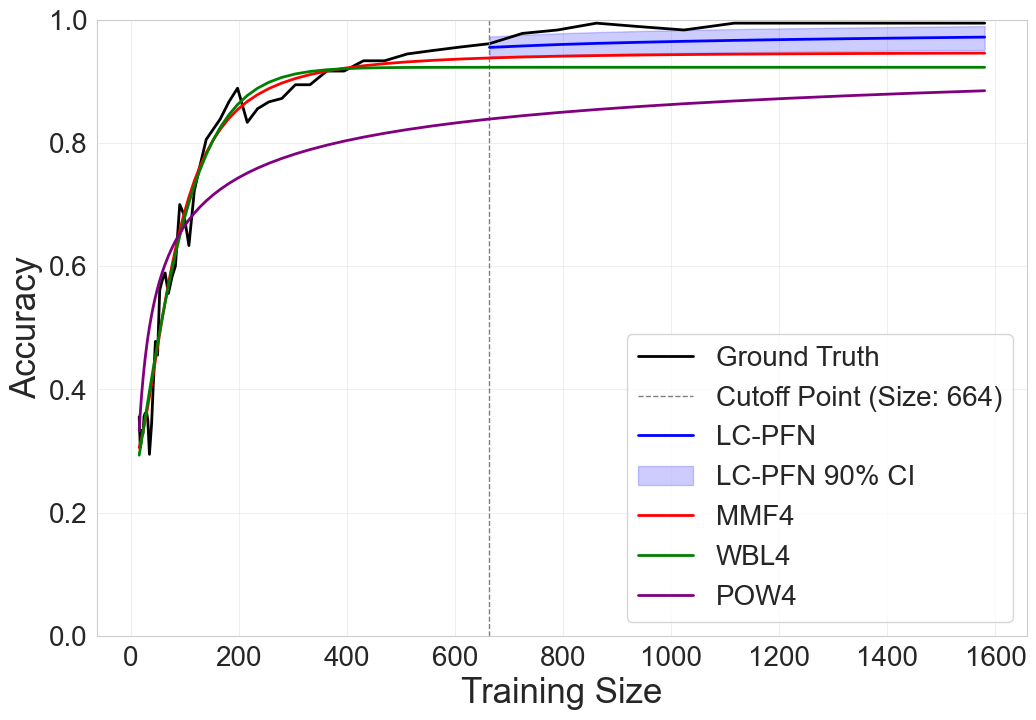

In [9]:
fig = compare_extrapolations(curve_idx=770, data=test_data_KDKL, anchor_sizes=ANCHOR_SIZE, lcpfn_model=model, cutoff_percentage=0.8)
plt.show()

## Performance Evaluation Metrics

In [10]:
def calculate_smape(y_true, y_pred):
    denominator = np.abs(y_true) + np.abs(y_pred)
    return 100 * np.mean(np.where(denominator == 0, 0, np.abs(y_pred - y_true) / denominator))

def calculate_mae(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))

def calculate_mse(y_true, y_pred):
    return np.mean((y_true - y_pred) ** 2)

In [11]:
def evaluate_extrapolations(curve_idx, data, anchor_sizes, lcpfn_model, min_points=10,
                           random_cutoff=True, fixed_cutoff_idx=None, cutoff_percentage=None):
    """
    Evaluate extrapolations of a learning curve using LC-PFN and parametric models.

    Args:
        curve_idx: Index of the learning curve to use
        data: Array of learning curves
        anchor_sizes: Training sizes corresponding to the curve points
        lcpfn_model: Trained LC-PFN model
        min_points: Minimum number of points to use for fitting
        random_cutoff: If True, uses a random cutoff point
        fixed_cutoff_idx: If provided, uses this specific cutoff index instead of generating a random one
        cutoff_percentage: If provided, uses this percentage of the curve for training

    Returns:
        Dictionary with SMAPE and MASE metrics for each model
    """

    curve = data[curve_idx].flatten()
    valid_mask = np.isfinite(curve)
    curve = curve[valid_mask]

    if len(curve) <= min_points:
        return None

    curve_anchor_sizes = anchor_sizes[:len(curve)]

    if cutoff_percentage is not None:
        cutoff_idx = max(min_points, int(cutoff_percentage * len(curve)))
        cutoff_idx = min(cutoff_idx, len(curve) - 1)
    elif fixed_cutoff_idx is not None:
        cutoff_idx = fixed_cutoff_idx
    elif random_cutoff:
        cutoff_idx = random.randint(min_points, len(curve) - 1)
    else:
        cutoff_idx = len(curve) - 1

    x_train_pfn, y_train_pfn, x_test_pfn, y_test_pfn, pred_mean, _, _ = extrapolate_lcpfn(
        curve, anchor_sizes, lcpfn_model, min_points=min_points,
        random_cutoff=False, fixed_cutoff_idx=cutoff_idx
    )

    results = {'LC-PFN': (y_test_pfn, pred_mean, y_train_pfn)}
    for model_name in ["MMF4", "WBL4", "POW4"]:
        result = extrapolate_parametric(
            curve, anchor_sizes, model_name, min_points=min_points,
            random_cutoff=False, fixed_cutoff_idx=cutoff_idx
        )
        if result[0] is not None:
            x_train, y_train, x_test, y_test, y_pred_full = result
            y_pred_test = y_pred_full[cutoff_idx:]
            results[model_name] = (y_test, y_pred_test, y_train)

    metrics = {}
    for model_name, (y_true, y_pred, y_train) in results.items():
        smape = calculate_smape(y_true, y_pred)
        mae = calculate_mae(y_true, y_pred)
        mse = calculate_mse(y_true, y_pred)
        metrics[model_name] = {'SMAPE': smape, 'MAE': mae, 'MSE': mse}

    return metrics

In [12]:
def compare_multiple_curves(data_indices, data, anchor_sizes, lcpfn_model, min_points=10):
    """
    Compare and evaluate extrapolations for multiple learning curves.

    Args:
        data_indices: List of indices for the curves to evaluate
        data: Array of learning curves
        anchor_sizes: Training sizes corresponding to the curve points
        lcpfn_model: Trained LC-PFN model
        min_points: Minimum number of points to use for fitting

    Returns:
        DataFrame with average metrics across curves
    """

    all_metrics = []

    for idx in tqdm(data_indices):
        metrics = evaluate_extrapolations(idx, data, anchor_sizes, lcpfn_model, min_points=min_points, random_cutoff=True)

        if metrics is not None:
            for model, values in metrics.items():
                row = {'Curve_idx': idx, 'Model': model}
                row.update(values)
                all_metrics.append(row)

    df = pd.DataFrame(all_metrics)

    avg_metrics = df.groupby('Model').mean(numeric_only=True).drop(columns=['Curve_idx'])

    return df, avg_metrics

In [13]:
print(evaluate_extrapolations(102, test_data_UL, anchor_sizes=ANCHOR_SIZE, lcpfn_model=model, min_points=25))

{'LC-PFN': {'SMAPE': np.float32(3.444694), 'MAE': np.float32(0.048271857), 'MSE': np.float32(0.0031171239)}, 'MMF4': {'SMAPE': np.float64(3.1244243897140156), 'MAE': np.float64(0.04386452985621523), 'MSE': np.float64(0.002490436533905446)}, 'WBL4': {'SMAPE': np.float64(3.5815235430165404), 'MAE': np.float64(0.0500361422700927), 'MSE': np.float64(0.003260738023605983)}, 'POW4': {'SMAPE': np.float64(14.021516245247417), 'MAE': np.float64(0.17516519002159117), 'MSE': np.float64(0.031813787449822335)}}


In [14]:
CUTOFF_PERCENTAGES = [0.1, 0.3, 0.5, 0.7, 0.9]

def collect_metrics_for_all_scenarios_with_cutoffs(min_points=25, sample_size=500):

    all_results = []

    scenarios = {
        'KDKL': test_data_KDKL,
        'UD': test_data_UD,
        'UL': test_data_UL,
        'UDUL': test_data_UDUL
    }

    for scenario_name, data in scenarios.items():
        for cutoff_pct in CUTOFF_PERCENTAGES:
            if len(data) > sample_size:
                indices = random.sample(range(len(data)), sample_size)
            else:
                indices = range(len(data))

            print(f"Processing {scenario_name} scenario with {cutoff_pct*100:.0f}% cutoff ({len(indices)} curves)...")

            for idx in tqdm(indices):
                metrics = evaluate_extrapolations(
                    idx, data, ANCHOR_SIZE, model,
                    min_points=min_points,
                    random_cutoff=False,
                    cutoff_percentage=cutoff_pct
                )

                if metrics is not None:
                    for model_name, values in metrics.items():
                        row = {
                            'Model': model_name,
                            'Scenario': scenario_name,
                            'Cutoff_Percentage': cutoff_pct,
                            'Scenario_Cutoff': f"{scenario_name}_{cutoff_pct*100:.0f}%"
                        }
                        row.update(values)
                        all_results.append(row)

    return pd.DataFrame(all_results)

In [15]:
def evaluate_single_curve(args):
    """
    Wrapper function for evaluating a single curve.
    Needed for parallel processing to unpack arguments properly.
    """
    idx, data, anchor_sizes, model, min_points, cutoff_percentage = args

    try:
        metrics = evaluate_extrapolations(
            idx, data, anchor_sizes, model,
            min_points=min_points,
            random_cutoff=False,
            cutoff_percentage=cutoff_percentage
        )
        return idx, metrics
    except Exception as e:
        print(f"Error processing curve {idx}: {e}")
        return idx, None

def collect_metrics_parallel(min_points=25, sample_size=500, n_workers=None):
    """
    Parallel version of collect_metrics_for_all_scenarios_with_cutoffs.

    Args:
        min_points: Minimum points for fitting
        sample_size: Number of curves to sample per scenario
        n_workers: Number of parallel workers (default: number of CPUs - 1)
    """
    if n_workers is None:
        n_workers = max(1, mp.cpu_count() - 1)  # Leave one CPU free

    print(f"Using {n_workers} parallel workers")

    all_results = []

    scenarios = {
        'KDKL': test_data_KDKL,
        'UD': test_data_UD,
        'UL': test_data_UL,
        'UDUL': test_data_UDUL
    }

    for scenario_name, data in scenarios.items():
        for cutoff_pct in CUTOFF_PERCENTAGES:
            # Sample indices
            if len(data) > sample_size:
                indices = random.sample(range(len(data)), sample_size)
            else:
                indices = range(len(data))

            print(f"Processing {scenario_name} scenario with {cutoff_pct*100:.0f}% cutoff ({len(indices)} curves)...")

            # Prepare arguments for parallel processing
            args_list = [
                (idx, data, ANCHOR_SIZE, model, min_points, cutoff_pct)
                for idx in indices
            ]

            # Process curves in parallel
            with ThreadPoolExecutor(max_workers=n_workers) as executor:
                # Submit all tasks
                future_to_idx = {
                    executor.submit(evaluate_single_curve, args): args[0]
                    for args in args_list
                }

                # Collect results with progress bar
                scenario_results = []
                completed = 0

                for future in as_completed(future_to_idx):
                    idx, metrics = future.result()
                    completed += 1

                    # Print progress every 100 curves
                    if completed % 100 == 0:
                        print(f"  Completed {completed}/{len(indices)} curves")

                    if metrics is not None:
                        for model_name, values in metrics.items():
                            row = {
                                'Model': model_name,
                                'Scenario': scenario_name,
                                'Cutoff_Percentage': cutoff_pct,
                                'Scenario_Cutoff': f"{scenario_name}_{cutoff_pct*100:.0f}%",
                                'Curve_idx': idx
                            }
                            row.update(values)
                            scenario_results.append(row)

                all_results.extend(scenario_results)
                print(f"  Completed {scenario_name} {cutoff_pct*100:.0f}% - Processed {len(scenario_results)} valid results")

    return pd.DataFrame(all_results)

In [16]:
sample_size = 1000
file_path = Path(f'results_{sample_size}samples_parallel_{model_name}.csv')
if file_path.exists():
    df = pd.read_csv(file_path)
else:
    random.seed(42)
    np.random.seed(42)
    torch.manual_seed(42)
    df = collect_metrics_parallel(sample_size=sample_size, n_workers=6)  # Use 6 workers for 8 CPU allocation
    df.to_csv(file_path, index=False)  # Save results

Using 6 parallel workers
Processing KDKL scenario with 10% cutoff (5 curves)...
  Completed KDKL 10% - Processed 20 valid results
Processing KDKL scenario with 30% cutoff (5 curves)...
  Completed KDKL 30% - Processed 20 valid results
Processing KDKL scenario with 50% cutoff (5 curves)...
  Completed KDKL 50% - Processed 20 valid results
Processing KDKL scenario with 70% cutoff (5 curves)...
  Completed KDKL 70% - Processed 20 valid results
Processing KDKL scenario with 90% cutoff (5 curves)...
  Completed KDKL 90% - Processed 20 valid results
Processing UD scenario with 10% cutoff (5 curves)...
  Completed UD 10% - Processed 20 valid results
Processing UD scenario with 30% cutoff (5 curves)...
  Completed UD 30% - Processed 20 valid results
Processing UD scenario with 50% cutoff (5 curves)...
  Completed UD 50% - Processed 20 valid results
Processing UD scenario with 70% cutoff (5 curves)...
  Completed UD 70% - Processed 20 valid results
Processing UD scenario with 90% cutoff (5 curv

In [17]:
df['curve_idx'] = (df.index // 4) + 1
df.to_csv(file_path, index=False)

In [18]:
def create_poster_boxplot_comparison(df, figsize=(12, 8)):

    plt.style.use('default')
    plt.rcParams.update({
        'font.size': 9,
        'axes.labelsize': 10,
        'axes.titlesize': 11,
        'legend.fontsize': 8,
        'xtick.labelsize': 12,
        'ytick.labelsize': 12
    })

    model_colors = {
        'MMF4': '#1f77b4',    # Blue
        'WBL4': '#ff7f0e',    # Orange
        'POW4': '#2ca02c',    # Green
        'LC-PFN': '#d62728'   # Red
    }

    scenarios = ['KDKL', 'UD', 'UL', 'UDUL']
    scenario_labels = {
        'KDKL': 'Known Data - Known Learners',
        'UD': 'Unseen Data - Known Learners',
        'UL': 'Known Data - Unseen Learners',
        'UDUL': 'Unseen Data - Unseen Learners'
    }

    fig, axes = plt.subplots(2, 2, figsize=figsize, facecolor='white')
    #fig.suptitle('Learning Curve Extrapolation: SMAPE Performance by Transfer Scenario',
                 #fontsize=13, fontweight='bold', y=0.96)

    axes = axes.flatten()

    for idx, scenario in enumerate(scenarios):
        ax = axes[idx]
        scenario_data = df[df['Scenario'] == scenario]

        box_plot = sns.boxplot(data=scenario_data, x='Cutoff_Percentage', y='SMAPE',
                              hue='Model', ax=ax, palette=model_colors,
                              showfliers=False, linewidth=1.2,
                              boxprops=dict(alpha=0.8),
                              whiskerprops=dict(linewidth=1),
                              capprops=dict(linewidth=1))

        ax.set_title(scenario_labels[scenario], fontweight='bold', fontsize=13, pad=8)
        ax.set_xlabel('Cutoff %', fontsize=14)
        ax.set_ylabel('SMAPE (%)' if idx in [0, 2] else '', fontsize=14)

        cutoff_labels = [f'{int(float(label.get_text())*100)}%' for label in ax.get_xticklabels()]
        ax.set_xticklabels(cutoff_labels)

        ax.grid(True, alpha=0.2, axis='y', linestyle='-', linewidth=0.5)
        ax.set_axisbelow(True)

        ax.set_ylim(0, None)

        if idx == 1:
            handles, labels = ax.get_legend_handles_labels()
            ax.legend(handles, labels, bbox_to_anchor=(1.05, 1), loc='upper left',
                     fontsize=14, frameon=True, fancybox=True, shadow=True)
        else:
            ax.legend().remove()

    plt.tight_layout()
    plt.subplots_adjust(top=0.89, right=0.82, hspace=0.3, wspace=0.25)

    return fig

def create_compact_scenario_boxplots(df, metric='SMAPE', figsize=(12, 4)):

    plt.rcParams.update({
        'font.size': 9,
        'axes.labelsize': 10,
        'axes.titlesize': 11,
        'legend.fontsize': 8
    })

    model_colors = {
        'MMF4': '#1f77b4',
        'WBL4': '#ff7f0e',
        'POW4': '#2ca02c',
        'LC-PFN': '#d62728'
    }

    scenarios = ['KDKL', 'UD', 'UL', 'UDUL']

    fig, axes = plt.subplots(1, 4, figsize=figsize, facecolor='white', sharey=True)
    fig.suptitle(f'{metric} Performance Across Transfer Scenarios and Cutoff Percentages',
                 fontsize=12, fontweight='bold', y=0.95)

    for idx, scenario in enumerate(scenarios):
        ax = axes[idx]
        scenario_data = df[df['Scenario'] == scenario]

        sns.boxplot(data=scenario_data, x='Cutoff_Percentage', y=metric,
                   hue='Model', ax=ax, palette=model_colors,
                   showfliers=False, linewidth=1,
                   boxprops=dict(alpha=0.8),
                   whiskerprops=dict(linewidth=0.8),
                   capprops=dict(linewidth=0.8))

        ax.set_title(scenario, fontweight='bold', fontsize=10)
        ax.set_xlabel('Cutoff %', fontsize=9)
        ax.set_ylabel(f'{metric} (%)' if metric == 'SMAPE' and idx == 0 else
                     f'{metric}' if metric == 'MASE' and idx == 0 else '', fontsize=9)

        cutoff_labels = [f'{int(float(label.get_text())*100)}%' for label in ax.get_xticklabels()]
        ax.set_xticklabels(cutoff_labels, rotation=45)

        ax.grid(True, alpha=0.2, axis='y')

        if idx == 3:
            handles, labels = ax.get_legend_handles_labels()
            ax.legend(handles, labels, bbox_to_anchor=(1.05, 1), loc='upper left',
                     fontsize=7, frameon=True)
        else:
            ax.legend().remove()

    plt.tight_layout()
    plt.subplots_adjust(top=0.85, right=0.88)

    return fig


def create_mini_summary_boxplot(df, figsize=(8, 5)):

    plt.rcParams.update({
        'font.size': 8,
        'axes.labelsize': 9,
        'axes.titlesize': 10,
        'legend.fontsize': 7
    })

    model_colors = {
        'MMF4': '#1f77b4',
        'WBL4': '#ff7f0e',
        'POW4': '#2ca02c',
        'LC-PFN': '#d62728'
    }

    fig, ax = plt.subplots(figsize=figsize, facecolor='white')

    sns.boxplot(data=df, x='Model', y='SMAPE', ax=ax,
               palette=model_colors, showfliers=False,
               boxprops=dict(alpha=0.8), linewidth=1.2,
               whiskerprops=dict(linewidth=1),
               capprops=dict(linewidth=1))

    ax.set_title('Overall SMAPE Performance Across All Scenarios',
                 fontweight='bold', fontsize=11)
    ax.set_xlabel('Model', fontsize=10)
    ax.set_ylabel('SMAPE (%)', fontsize=10)
    ax.grid(True, alpha=0.2, axis='y')

    plt.tight_layout()

    return fig

def create_performance_ranking_table(df):

    rankings = []

    for cutoff in df['Cutoff_Percentage'].unique():
        for scenario in df['Scenario'].unique():
            subset = df[(df['Cutoff_Percentage'] == cutoff) & (df['Scenario'] == scenario)]

            if len(subset) > 0:
                mean_metrics = subset.groupby('Model')[['SMAPE', 'MAE', 'MSE']].mean()
                smape_ranking = mean_metrics['SMAPE'].rank().to_dict()
                mae_ranking = mean_metrics['MAE'].rank().to_dict()
                mse_ranking = mean_metrics['MSE'].rank().to_dict()

                for model in mean_metrics.index:
                    rankings.append({
                        'Cutoff_Percentage': cutoff,
                        'Scenario': scenario,
                        'Model': model,
                        'SMAPE_Mean': mean_metrics.loc[model, 'SMAPE'],
                        'SMAPE_Rank': smape_ranking[model],
                        'MAE_Mean': mean_metrics.loc[model, 'MAE'],
                        'MAE_Rank': mae_ranking[model],
                        'MSE_Mean': mean_metrics.loc[model, 'MSE'],
                        'MSE_Rank': mse_ranking[model],
                        'Average_Rank': (smape_ranking[model] + mae_ranking[model] + mse_ranking[model]) / 3
                    })

    ranking_df = pd.DataFrame(rankings)
    return ranking_df.round(3)

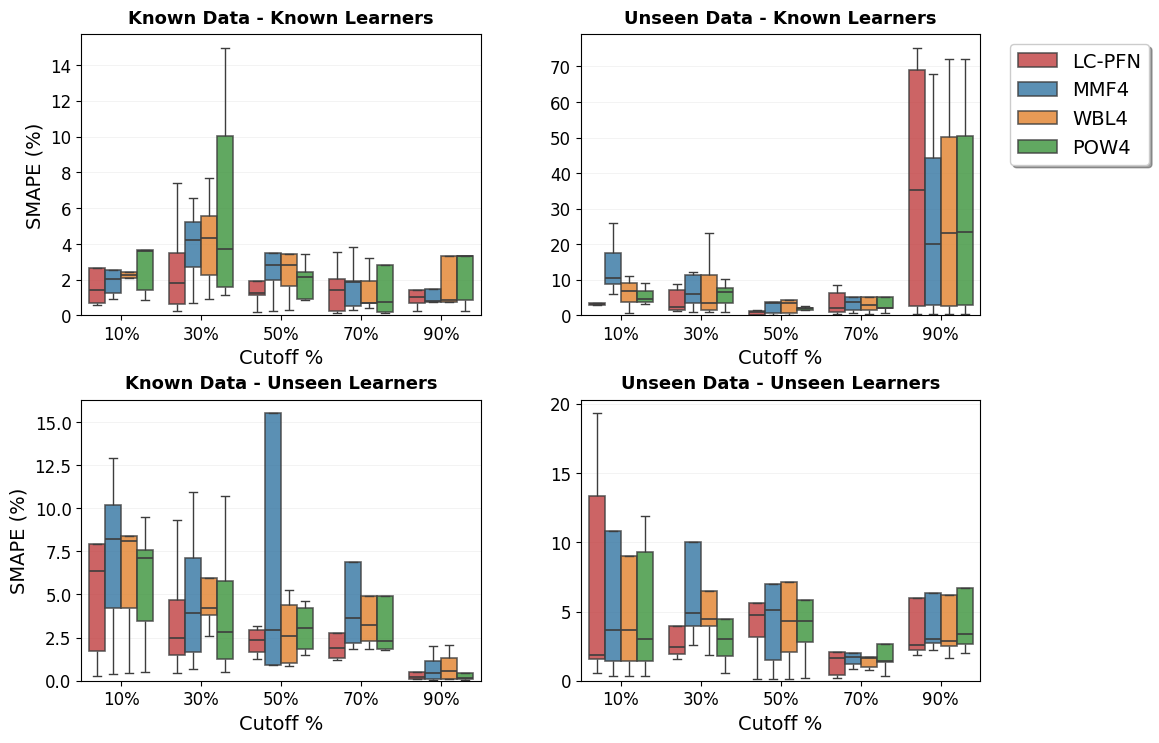

In [19]:
fig = create_poster_boxplot_comparison(df, figsize=(12, 8))
plt.show()

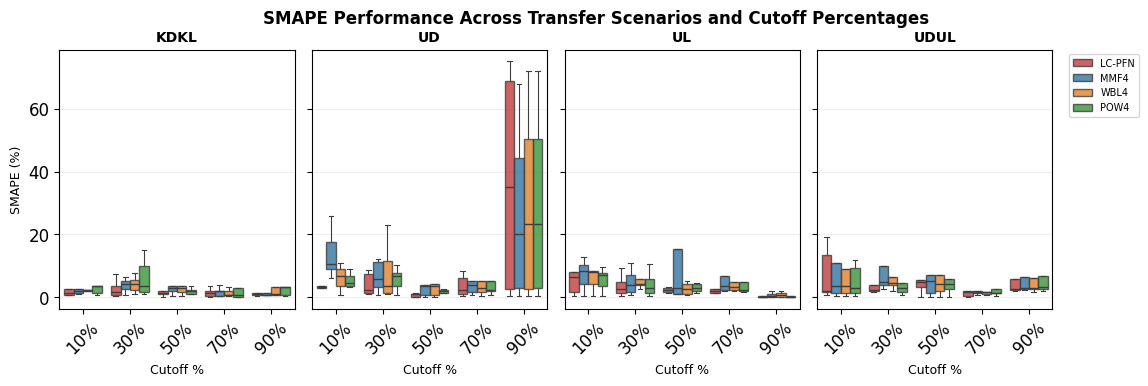

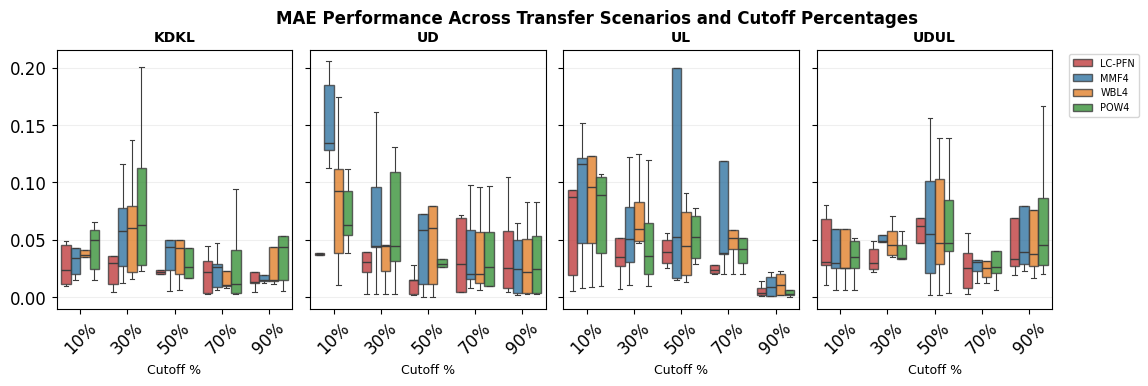

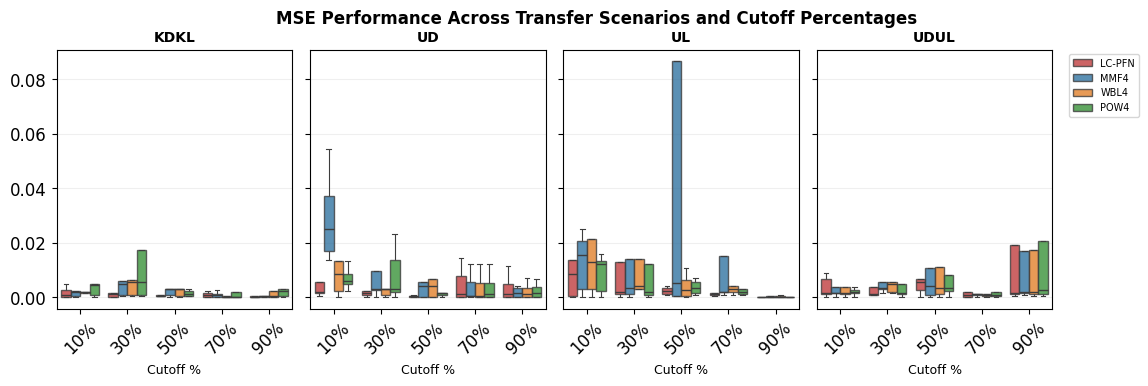

In [20]:
fig = create_compact_scenario_boxplots(df, metric='SMAPE', figsize=(12, 4))
plt.savefig('../visuals - experiment 1/scenario_cutoff_smape.png')
plt.show()

fig = create_compact_scenario_boxplots(df, metric='MAE', figsize=(12, 4))
plt.savefig('../visuals - experiment 1/scenario_cutoff_mae.png')
plt.show()

fig = create_compact_scenario_boxplots(df, metric='MSE', figsize=(12, 4))
plt.savefig('../visuals - experiment 1/scenario_cutoff_mse.png')
plt.show()

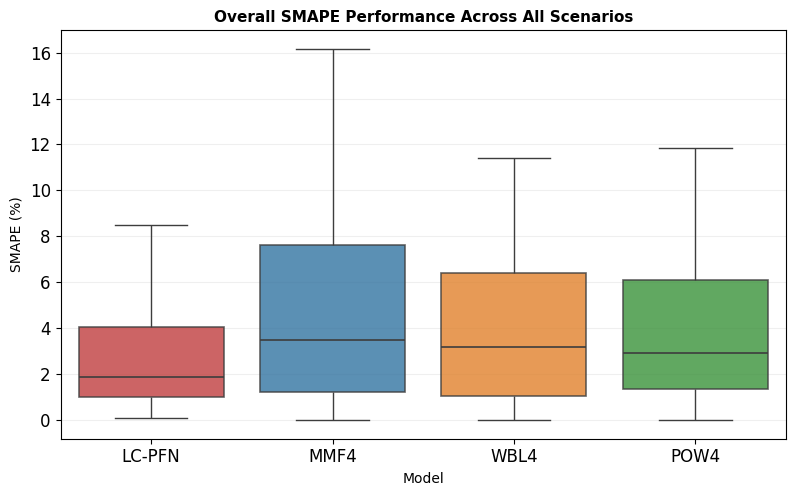

In [21]:
fig = create_mini_summary_boxplot(df, figsize=(8, 5))
plt.show()

In [22]:
def create_three_metric_boxplot(df, figsize=(16, 12)):

    plt.rcParams.update({
        'font.size': 9,
        'axes.labelsize': 10,
        'axes.titlesize': 11,
        'legend.fontsize': 8
    })

    model_colors = {
        'MMF4': '#1f77b4',
        'WBL4': '#ff7f0e',
        'POW4': '#2ca02c',
        'LC-PFN': '#d62728'
    }

    metrics = ['SMAPE', 'MAE', 'MSE']
    metric_labels = {
        'SMAPE': 'SMAPE (%)',
        'MAE': 'MAE',
        'MSE': 'MSE'
    }

    fig, axes = plt.subplots(3, 1, figsize=figsize, facecolor='white')
    fig.suptitle('Model Performance Across All Metrics & Transfer Scenarios',
                 fontsize=25, fontweight='bold', y=0.95)

    axes = axes.flatten()

    for idx, metric in enumerate(metrics):
        ax = axes[idx]

        sns.boxplot(data=df, x='Scenario', y=metric, hue='Model',
                   ax=ax, palette=model_colors, showfliers=False,
                   boxprops=dict(alpha=0.8), linewidth=1.2,
                   whiskerprops=dict(linewidth=1),
                   capprops=dict(linewidth=1))

        ax.set_title(f'{metric} Performance', fontweight='bold', fontsize=21)
        ax.set_xlabel('Transfer Scenario', fontsize=18)
        ax.set_ylabel(metric_labels[metric], fontsize=18)
        ax.grid(True, alpha=0.2, axis='y')

        if idx == 0:  # Show legend only on first plot
            handles, labels = ax.get_legend_handles_labels()
            ax.legend(handles, labels, bbox_to_anchor=(1.02, 1), loc='upper left',
                     fontsize=19, frameon=True)
        else:
            ax.legend().remove()

    plt.tight_layout()
    plt.subplots_adjust(top=0.88, right=0.85, hspace=0.7)

    return fig

def create_metric_comparison_by_cutoff(df, metrics=['SMAPE', 'MAE', 'MSE'], figsize=(16, 12)):

    model_colors = {
        'MMF4': '#1f77b4',
        'WBL4': '#ff7f0e',
        'POW4': '#2ca02c',
        'LC-PFN': '#d62728'
    }

    n_metrics = len(metrics)
    fig, axes = plt.subplots(n_metrics, 1, figsize=figsize, facecolor='white')

    if n_metrics == 1:
        axes = [axes]

    fig.suptitle('Model Performance Across Cutoff Percentages by Metric',
                 fontsize=25, fontweight='bold', y=0.95)

    for idx, metric in enumerate(metrics):
        ax = axes[idx]

        sns.boxplot(data=df, x='Cutoff_Percentage', y=metric, hue='Model',
                   ax=ax, palette=model_colors, showfliers=False,
                   boxprops=dict(alpha=0.8), linewidth=1.2)

        ax.set_title(f'{metric} Performance by Cutoff Percentage', fontweight='bold', fontsize=21)
        ax.set_xlabel('Cutoff Percentage', fontsize=18)
        ax.set_ylabel(metric, fontsize=18)
        ax.grid(True, alpha=0.2, axis='y')

        cutoff_labels = [f'{int(float(label.get_text())*100)}%' for label in ax.get_xticklabels()]
        ax.set_xticklabels(cutoff_labels)

        if idx == 0:
            handles, labels = ax.get_legend_handles_labels()
            ax.legend(handles, labels, bbox_to_anchor=(1.02, 1), loc='upper left',
                     fontsize=19, frameon=True)
        else:
            ax.legend().remove()

    plt.tight_layout()
    plt.subplots_adjust(top=0.88, right=0.85, hspace=0.7)

    return fig

In [23]:
def perform_pairwise_ttests(df, metric='SMAPE', alpha=0.05):

    models = df['Model'].unique()
    results = []

    for scenario in df['Scenario'].unique():
        for cutoff in df['Cutoff_Percentage'].unique():
            subset = df[(df['Scenario'] == scenario) & (df['Cutoff_Percentage'] == cutoff)]

            if len(subset) == 0:
                continue

            for model1, model2 in itertools.combinations(models, 2):
                data1 = subset[subset['Model'] == model1][metric].values
                data2 = subset[subset['Model'] == model2][metric].values

                if len(data1) > 1 and len(data2) > 1:
                    t_stat, p_value = stats.ttest_ind(data1, data2)

                    results.append({
                        'Scenario': scenario,
                        'Cutoff_Percentage': cutoff,
                        'Model1': model1,
                        'Model2': model2,
                        'Metric': metric,
                        'T_Statistic': t_stat,
                        'P_Value': p_value,
                        'Significant': p_value < alpha,
                        'Mean_Diff': np.mean(data1) - np.mean(data2),
                        'Model1_Mean': np.mean(data1),
                        'Model2_Mean': np.mean(data2)
                    })

    return pd.DataFrame(results)

def create_significance_heatmap(ttest_results, metric='SMAPE', figsize=(12, 8)):

    plt.rcParams.update({
        'xtick.labelsize': 26,
        'ytick.labelsize': 26
    })

    metric_results = ttest_results[ttest_results['Metric'] == metric]
    models = sorted(list(set(metric_results['Model1'].unique()) | set(metric_results['Model2'].unique())))

    significance_matrix = np.ones((len(models), len(models)))

    for _, row in metric_results.iterrows():
        i = models.index(row['Model1'])
        j = models.index(row['Model2'])
        significance_matrix[i, j] = row['P_Value']
        significance_matrix[j, i] = row['P_Value']

    fig, ax = plt.subplots(figsize=figsize)

    custom_cmap = LinearSegmentedColormap.from_list("custom_cmap", ['#BF1A2F', '#E49AB0', '#ECB8A5', '#ECCFC3'])
    sns.heatmap(significance_matrix,
                xticklabels=models,
                yticklabels=models,
                annot=True,
                fmt='.1e',
                cmap=custom_cmap,
                ax=ax,
                annot_kws={'size': 24},
                cbar_kws={'label': 'p-value'})
    ax.figure.axes[-1].yaxis.label.set_size(24)
    ax.tick_params(axis='y', labelrotation=0)

    ax.set_title(f'', fontsize=22)
    plt.tight_layout()

    return fig

def create_effect_size_analysis(df, metric='SMAPE'):

    models = df['Model'].unique()
    results = []

    for scenario in df['Scenario'].unique():
        for cutoff in df['Cutoff_Percentage'].unique():
            subset = df[(df['Scenario'] == scenario) & (df['Cutoff_Percentage'] == cutoff)]

            if len(subset) == 0:
                continue

            for model1, model2 in itertools.combinations(models, 2):
                data1 = subset[subset['Model'] == model1][metric].values
                data2 = subset[subset['Model'] == model2][metric].values

                if len(data1) > 1 and len(data2) > 1:
                    # Calculate Cohen's d
                    pooled_std = np.sqrt(((len(data1) - 1) * np.var(data1, ddof=1) +
                                        (len(data2) - 1) * np.var(data2, ddof=1)) /
                                       (len(data1) + len(data2) - 2))
                    cohens_d = (np.mean(data1) - np.mean(data2)) / pooled_std

                    if abs(cohens_d) < 0.2:
                        effect_size = "Negligible"
                    elif abs(cohens_d) < 0.5:
                        effect_size = "Small"
                    elif abs(cohens_d) < 0.8:
                        effect_size = "Medium"
                    else:
                        effect_size = "Large"

                    results.append({
                        'Scenario': scenario,
                        'Cutoff_Percentage': cutoff,
                        'Model1': model1,
                        'Model2': model2,
                        'Metric': metric,
                        'Cohens_D': cohens_d,
                        'Effect_Size': effect_size,
                        'Model1_Mean': np.mean(data1),
                        'Model2_Mean': np.mean(data2)
                    })

    return pd.DataFrame(results)

Performing statistical analysis...
Summary of significant differences (p < 0.05):

SMAPE: 1 significant comparisons out of 120

MAE: 2 significant comparisons out of 120

MSE: 2 significant comparisons out of 120


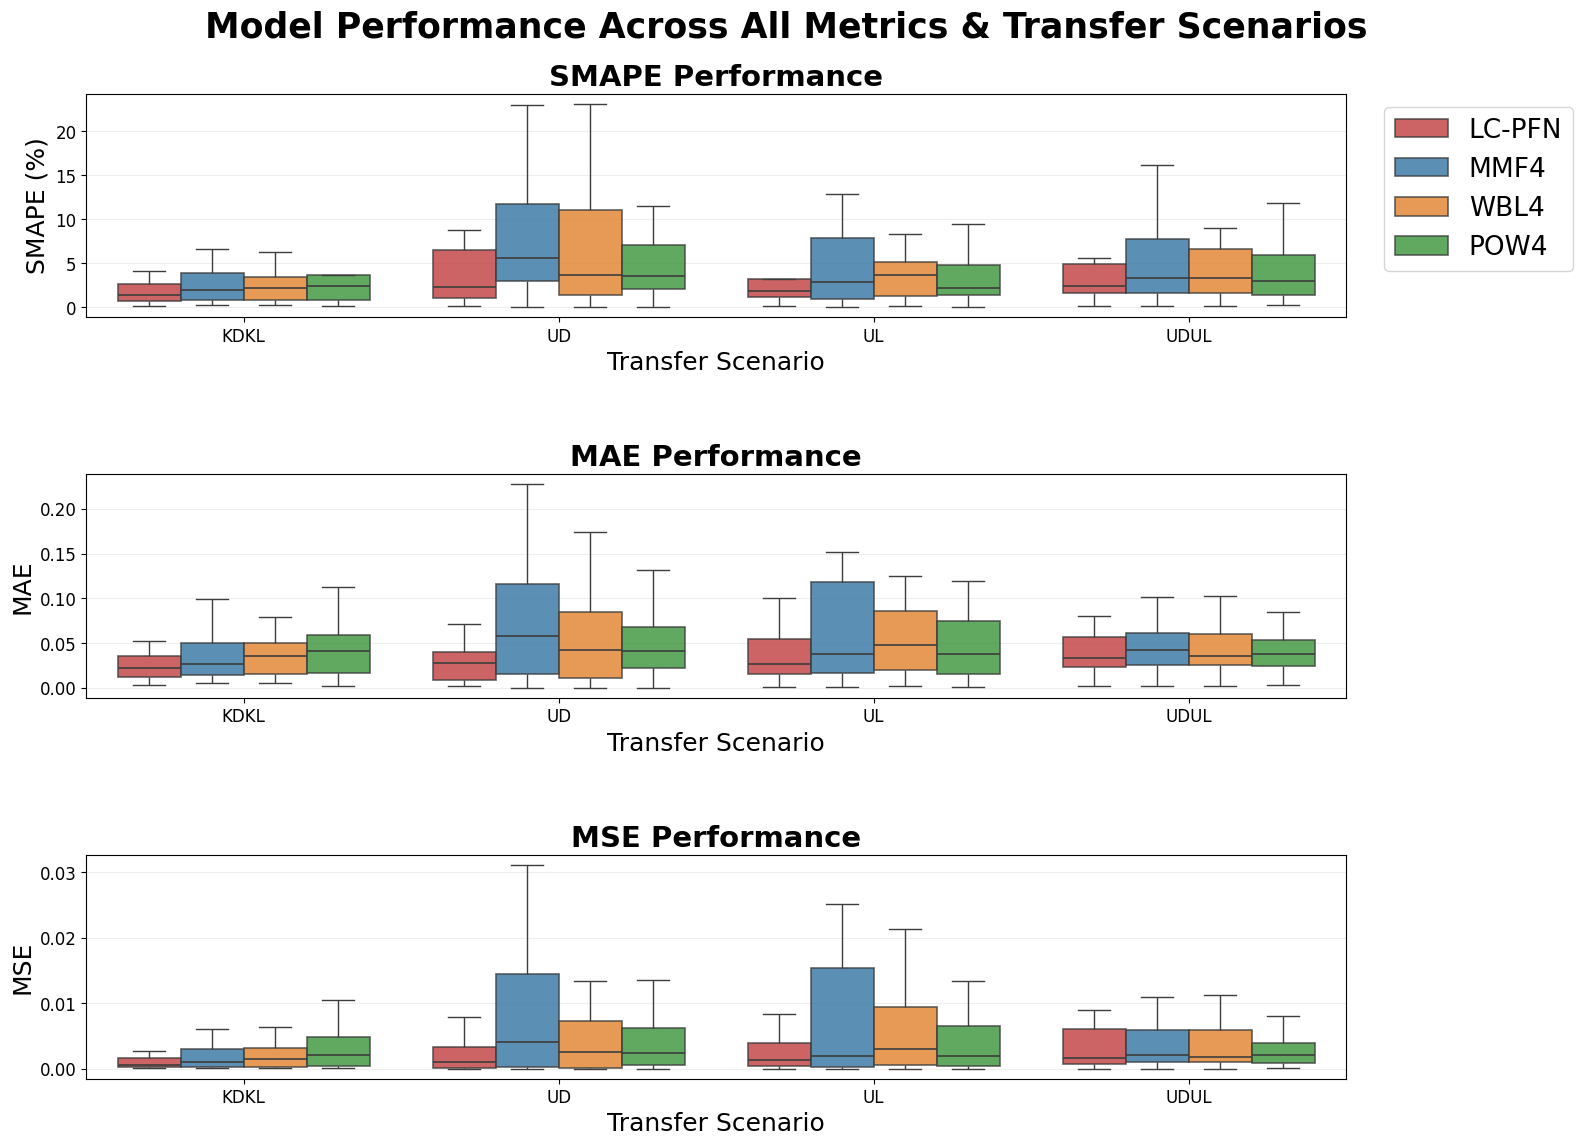

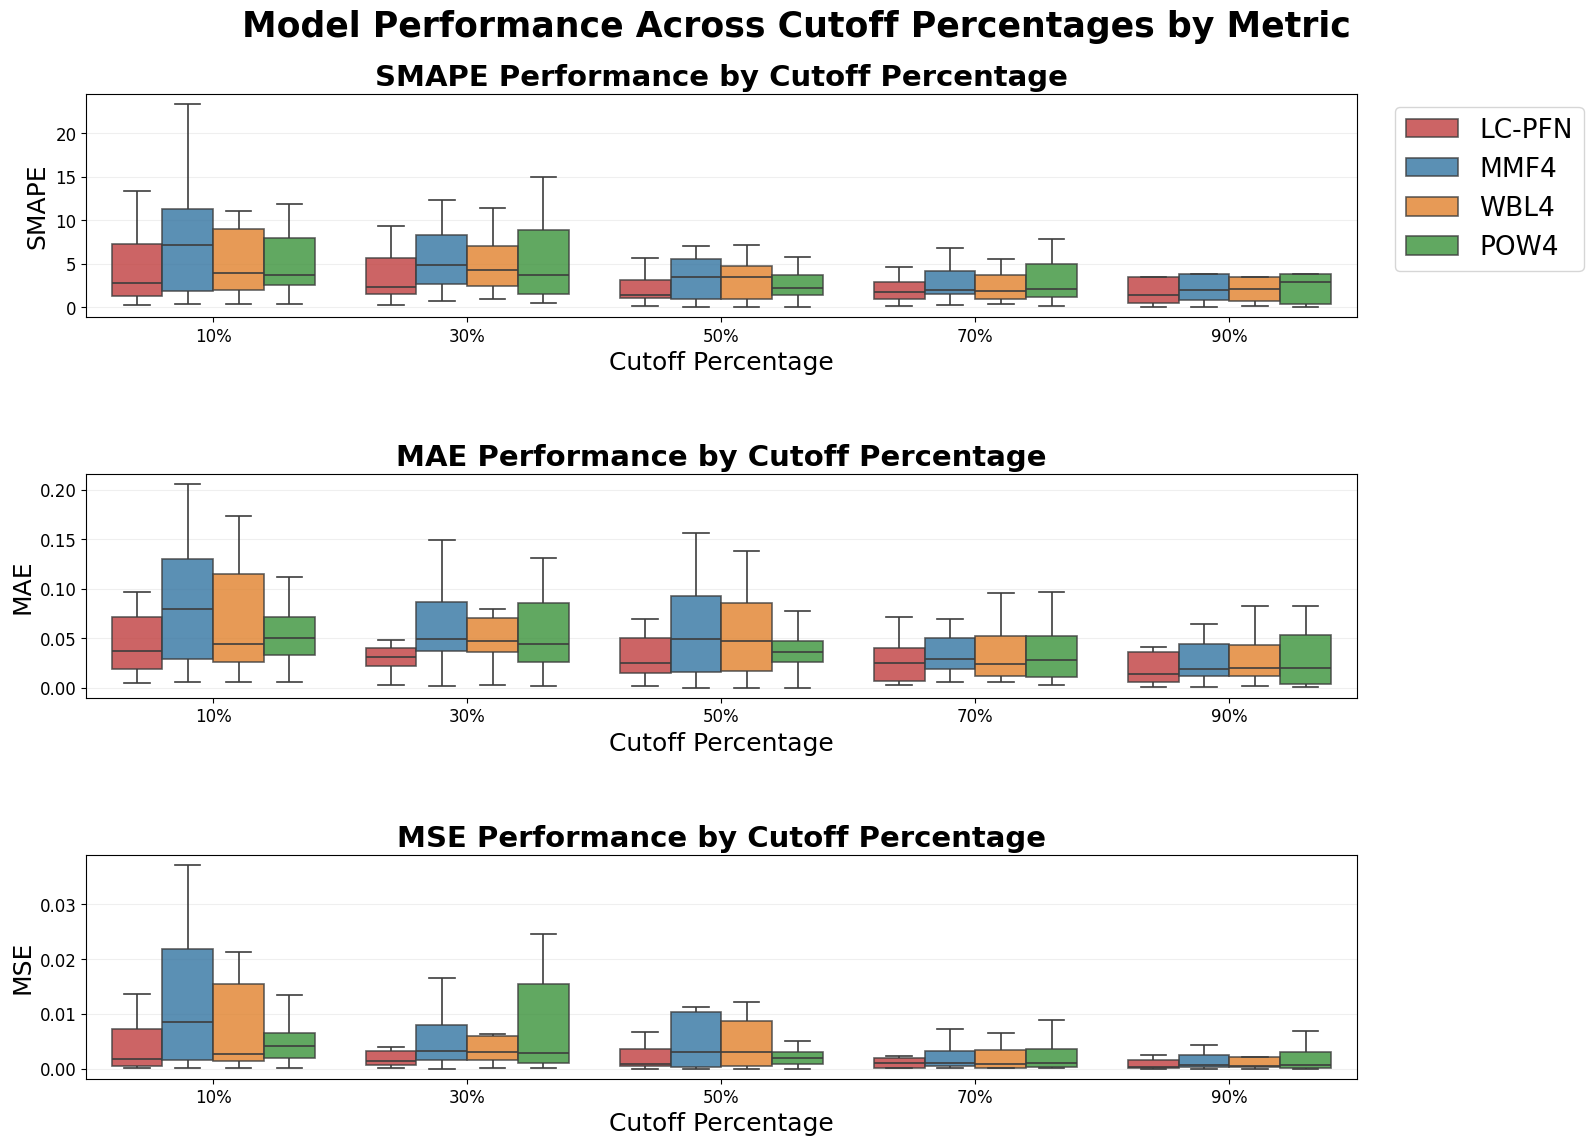

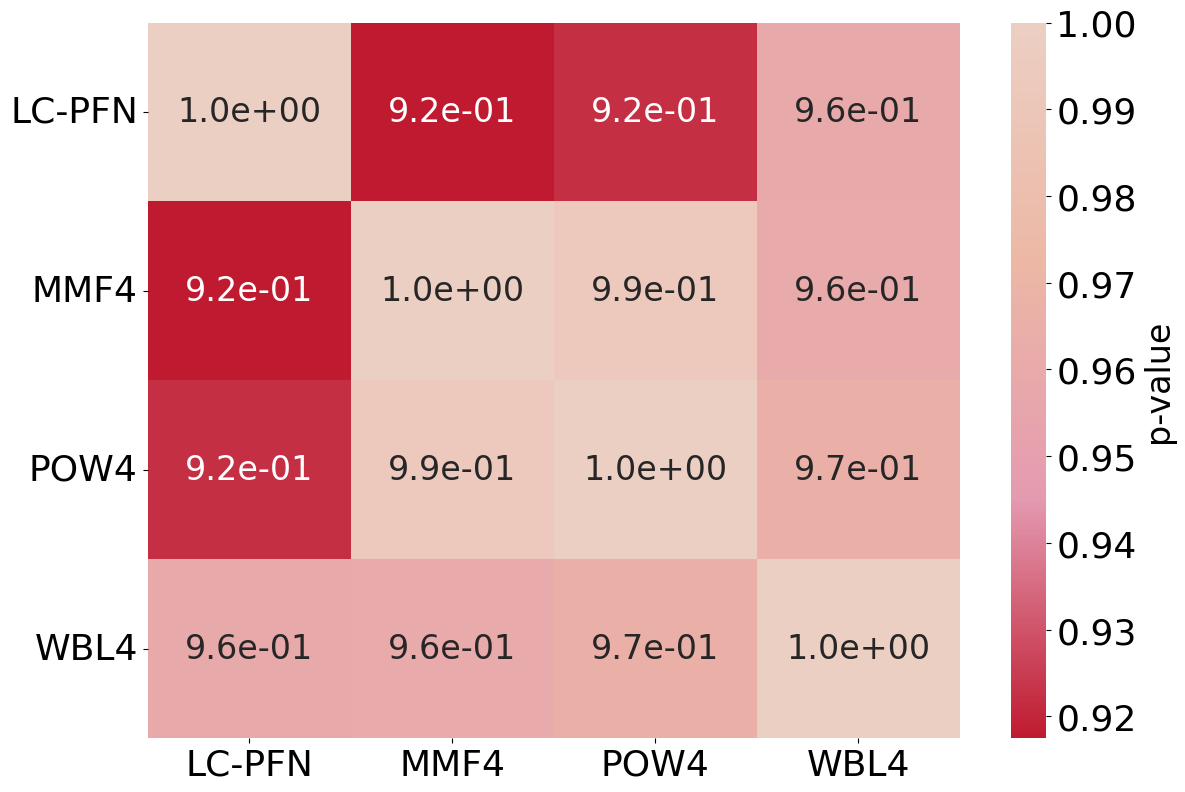

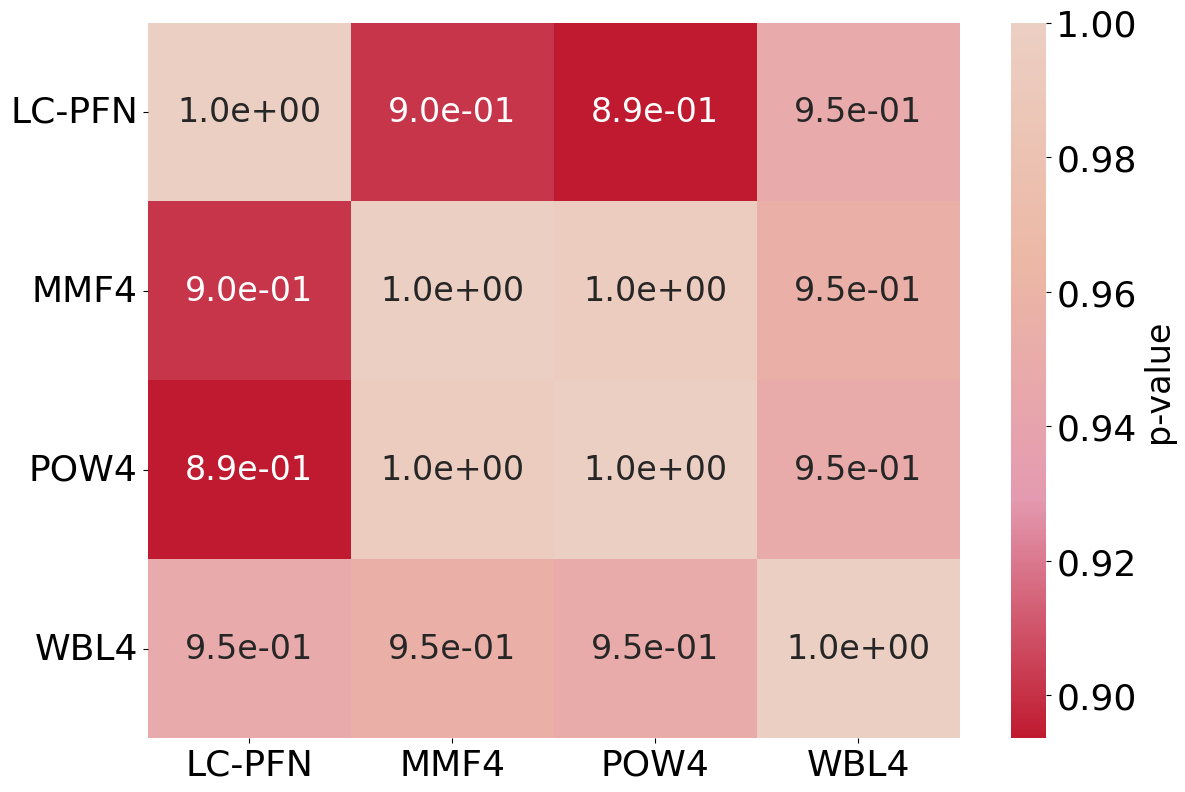

In [24]:
print("Performing statistical analysis...")

ttest_results_smape = perform_pairwise_ttests(df, metric='SMAPE')
ttest_results_mae = perform_pairwise_ttests(df, metric='MAE')
ttest_results_mse = perform_pairwise_ttests(df, metric='MSE')

all_ttest_results = pd.concat([ttest_results_smape, ttest_results_mae, ttest_results_mse], ignore_index=True)

effect_sizes_smape = create_effect_size_analysis(df, metric='SMAPE')
effect_sizes_mae = create_effect_size_analysis(df, metric='MAE')

print("Summary of significant differences (p < 0.05):")
for metric in ['SMAPE', 'MAE', 'MSE']:
    significant_results = all_ttest_results[
        (all_ttest_results['Metric'] == metric) &
        (all_ttest_results['Significant'] == True)
    ]
    print(f"\n{metric}: {len(significant_results)} significant comparisons out of {len(all_ttest_results[all_ttest_results['Metric'] == metric])}")

fig_four_metrics = create_three_metric_boxplot(df, figsize=(16, 12))
plt.savefig('../visuals - experiment 1/scenario.png')
plt.show()

fig_cutoff_comparison = create_metric_comparison_by_cutoff(df, figsize=(16, 12))
plt.savefig('../visuals - experiment 1/cutoff.png')
plt.show()

fig_sig_smape = create_significance_heatmap(all_ttest_results, metric='SMAPE')
plt.savefig('../visuals - experiment 1/ttest_smape.png')
plt.show()

fig_sig_mae = create_significance_heatmap(all_ttest_results, metric='MAE')
plt.savefig('../visuals - experiment 1/ttest_mae.png')
plt.show()

In [25]:
df['curve_idx'] = (df.index // 4) + 1
df['SMAPE_rank'] = df.groupby('curve_idx')['SMAPE'].rank(method='min')
df['MAE_rank'] = df.groupby('curve_idx')['MAE'].rank(method='min')
df['MSE_rank'] = df.groupby('curve_idx')['MSE'].rank(method='min')
df['Average_rank'] = df[['SMAPE_rank', 'MAE_rank', 'MSE_rank']].mean(axis=1)
df.to_csv(file_path, index=False)

smape_model_ranking = df.groupby('Model')['SMAPE_rank'].mean().sort_values()
print("SMAPE Rank Across All Scenarios and Cutoffs:")
print(smape_model_ranking)

mae_model_ranking = df.groupby('Model')['MAE_rank'].mean().sort_values()
print("MAE Rank Across All Scenarios and Cutoffs:")
print(mae_model_ranking)

mse_model_ranking = df.groupby('Model')['MSE_rank'].mean().sort_values()
print("MSE Rank Across All Scenarios and Cutoffs:")
print(mse_model_ranking)

final_model_ranking = df.groupby('Model')['Average_rank'].mean().sort_values()
print("Final Average Rank Across All Scenarios and Cutoffs:")
print(final_model_ranking)

metrics = ['SMAPE', 'MAE', 'MSE']
models = ['LC-PFN', 'MMF4', 'WBL4', 'POW4']

SMAPE Rank Across All Scenarios and Cutoffs:
Model
LC-PFN    1.905263
POW4      2.484211
WBL4      2.747368
MMF4      2.863158
Name: SMAPE_rank, dtype: float64
MAE Rank Across All Scenarios and Cutoffs:
Model
LC-PFN    1.894737
POW4      2.494737
WBL4      2.757895
MMF4      2.852632
Name: MAE_rank, dtype: float64
MSE Rank Across All Scenarios and Cutoffs:
Model
LC-PFN    2.073684
POW4      2.505263
WBL4      2.652632
MMF4      2.768421
Name: MSE_rank, dtype: float64
Final Average Rank Across All Scenarios and Cutoffs:
Model
LC-PFN    1.957895
POW4      2.494737
WBL4      2.719298
MMF4      2.828070
Name: Average_rank, dtype: float64


        SMAPE_rank  MAE_rank  MSE_rank  Average_rank
Model                                               
LC-PFN    1.905263  1.894737  2.073684      1.957895
MMF4      2.863158  2.852632  2.768421      2.828070
WBL4      2.747368  2.757895  2.652632      2.719298
POW4      2.484211  2.494737  2.505263      2.494737


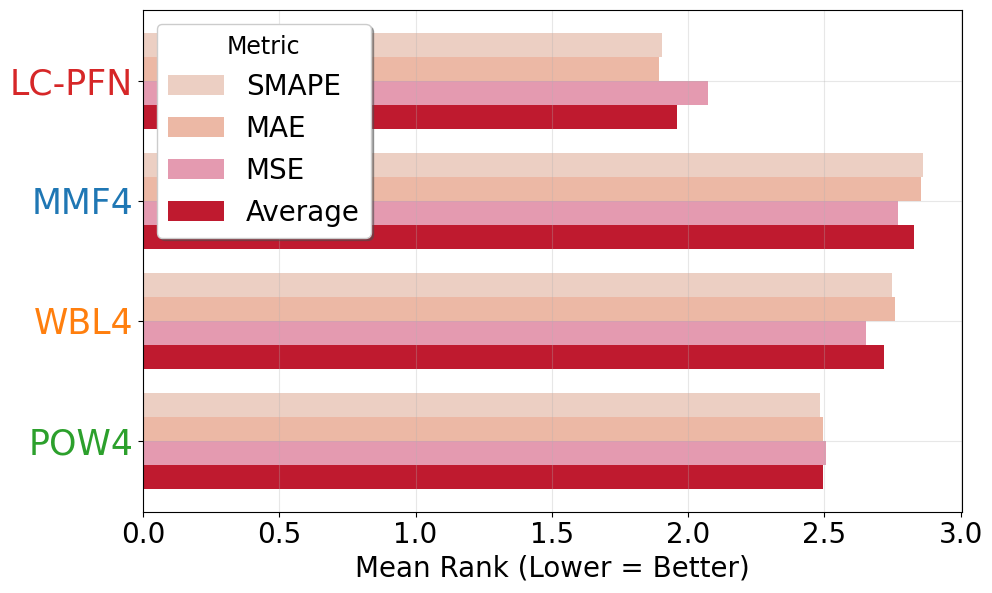

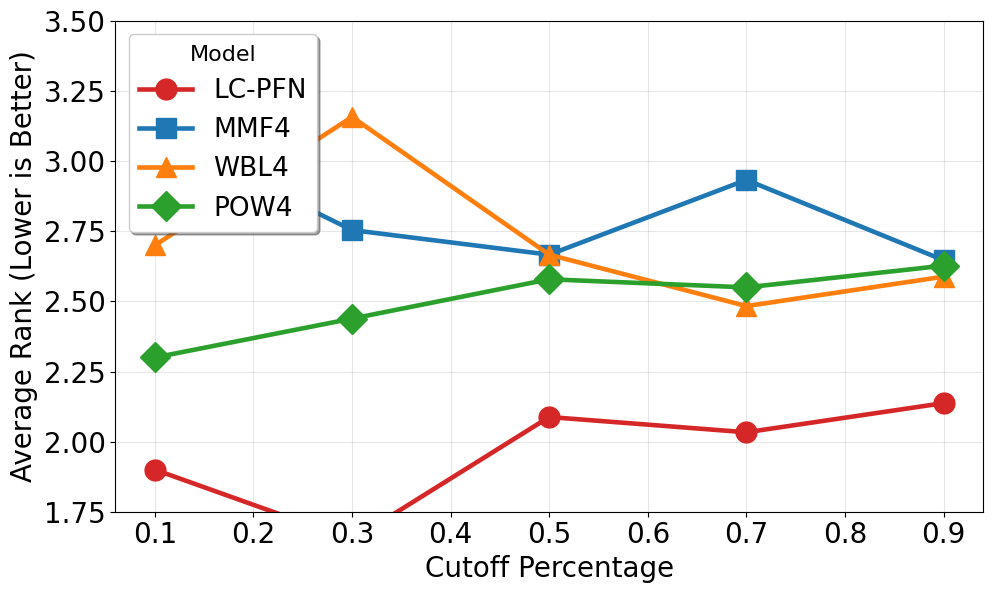

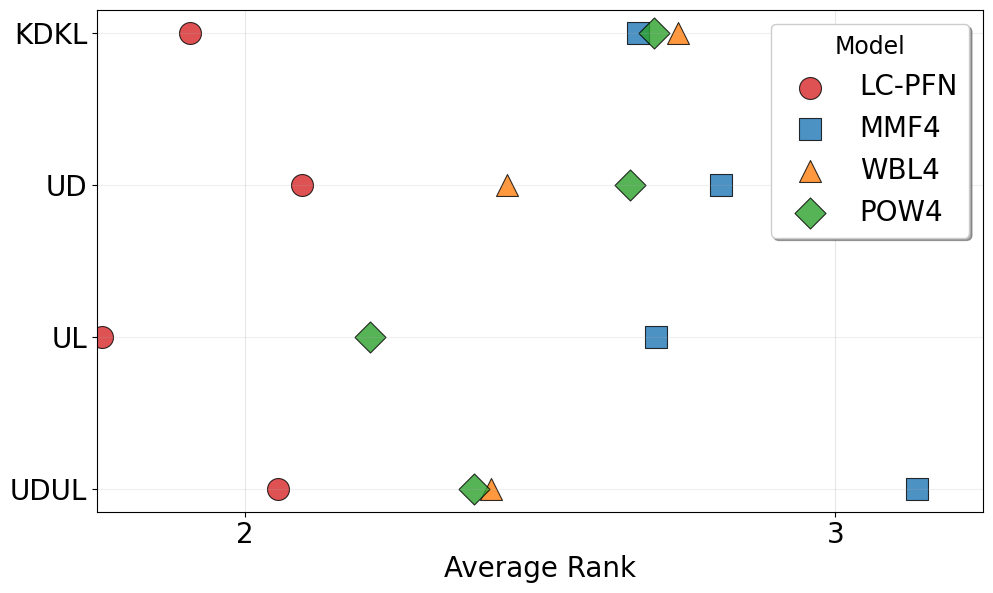

In [26]:
def plot_model_rankings_by_metric(df):
    plt.rcParams.update({
        'xtick.labelsize': 20,
        'ytick.labelsize': 25
    })

    avg_rankings = df.groupby('Model')[['SMAPE_rank', 'MAE_rank', 'MSE_rank', 'Average_rank']].mean()
    avg_rankings = avg_rankings.loc[models]

    print(avg_rankings)

    fig, ax = plt.subplots(figsize=(10, 6))

    colors = ['#ECCFC3', '#ECB8A5', '#E49AB0', '#BF1A2F']

    x = np.arange(len(avg_rankings.index))
    width = 0.8

    bars1 = ax.barh(x - 0.3, avg_rankings['SMAPE_rank'], width/4, label='SMAPE', color=colors[0])
    bars2 = ax.barh(x - 0.1, avg_rankings['MAE_rank'], width/4, label='MAE', color=colors[1])
    bars3 = ax.barh(x + 0.1, avg_rankings['MSE_rank'], width/4, label='MSE', color=colors[2])
    bars4 = ax.barh(x + 0.3, avg_rankings['Average_rank'], width/4, label='Average', color=colors[3])

    ax.invert_yaxis()
    ax.set_yticks(x)
    ax.set_yticklabels(avg_rankings.index)
    ax.set_xlabel('Mean Rank (Lower = Better)', fontsize=20)
    ax.set_title('', fontsize=18, fontweight='bold')
    ax.legend(title='Metric', loc='upper left', frameon=True, fancybox=True, shadow=True, fontsize=20, title_fontsize=17)
    ax.grid(True, alpha=0.3)

    model_colors = ['#d62728', '#1f77b4', '#ff7f0e', '#2ca02c']
    for ytick, color in zip(ax.get_yticklabels(), model_colors):
        ytick.set_color(color)

    plt.tight_layout()
    plt.savefig('../visuals - experiment 1/rankings_by_metric.png')
    return fig

def plot_rankings_by_cutoff(df):
    plt.rcParams.update({
        'xtick.labelsize': 20,
        'ytick.labelsize': 20
    })

    cutoff_rankings = df.groupby(['Model', 'Cutoff_Percentage'])['Average_rank'].mean().reset_index()

    fig, ax = plt.subplots(figsize=(10, 6))

    colors = ['#d62728', '#1f77b4', '#ff7f0e','#2ca02c']
    markers = ['o', 's', '^', 'D']

    for i, model in enumerate(models):
        model_data = cutoff_rankings[cutoff_rankings['Model'] == model]
        ax.plot(model_data['Cutoff_Percentage'], model_data['Average_rank'],
                marker=markers[i], color=colors[i], label=model, linewidth=3.3, markersize=15)

    ax.set_xlabel('Cutoff Percentage', fontsize=20)
    ax.set_ylabel('Average Rank (Lower is Better)', fontsize=20)
    ax.set_title('', fontsize=18, fontweight='bold')
    ax.legend(title='Model', loc='upper left', frameon=True, fancybox=True, shadow=True, fontsize=19, title_fontsize=16)
    ax.grid(True, alpha=0.3)
    ax.set_ylim(1.75, 3.5)

    plt.tight_layout()
    plt.savefig('../visuals - experiment 1/rankings_by_cutoff.png')
    return fig

def plot_rankings_by_scenario(df):
    plt.rcParams.update({
        'xtick.labelsize': 20,
        'ytick.labelsize': 20
    })

    scenario_rankings = df.groupby(['Model', 'Scenario'])['Average_rank'].mean().reset_index()

    fig, ax = plt.subplots(figsize=(10, 6))
    scenarios = ['KDKL', 'UD', 'UL', 'UDUL']

    colors = ['#d62728', '#1f77b4', '#ff7f0e','#2ca02c']
    markers = ['o', 's', '^', 'D']

    y_positions = np.arange(len(scenarios))

    for i, model in enumerate(models):
        model_data = scenario_rankings[scenario_rankings['Model'] == model]

        x_values = []
        y_values = []

        for j, scenario in enumerate(scenarios):
            scenario_data = model_data[model_data['Scenario'] == scenario]
            if len(scenario_data) > 0:
                x_values.append(scenario_data['Average_rank'].iloc[0])
                y_values.append(j)

        ax.scatter(x_values, y_values, color=colors[i], marker=markers[i], s=250,
                   label=model, alpha=0.8, edgecolors='black', linewidth=0.8)

    ax.set_xlabel('Average Rank', fontsize=20)
    ax.set_ylabel('')
    ax.set_title('', fontsize=18, fontweight='bold')

    ax.set_yticks(y_positions)
    ax.set_yticklabels(scenarios)

    ax.set_xlim(1.75, 3.25)
    ax.set_xticks([2, 3])

    ax.grid(True, alpha=0.3, axis='x')
    ax.grid(True, alpha=0.2, axis='y')

    ax.legend(title='Model', loc='upper right', frameon=True, fancybox=True, shadow=True, fontsize=20, title_fontsize=17)

    ax.invert_yaxis()

    plt.tight_layout()
    plt.savefig('../visuals - experiment 1/rankings_by_scenario.png')
    return fig

fig1 = plot_model_rankings_by_metric(df)
fig2 = plot_rankings_by_cutoff(df)
fig3 = plot_rankings_by_scenario(df)

In [27]:
ranking_df = create_performance_ranking_table(df)

smape_model_ranking = ranking_df.groupby('Model')['SMAPE_Rank'].mean().sort_values()
print("SMAPE Rank Across All Scenarios and Cutoffs:")
print(smape_model_ranking)

mae_model_ranking = ranking_df.groupby('Model')['MAE_Rank'].mean().sort_values()
print("MAE Rank Across All Scenarios and Cutoffs:")
print(mae_model_ranking)

mse_model_ranking = ranking_df.groupby('Model')['MSE_Rank'].mean().sort_values()
print("MSE Rank Across All Scenarios and Cutoffs:")
print(mse_model_ranking)

# Compute average rank per model across all scenarios and cutoffs
final_model_ranking = ranking_df.groupby('Model')['Average_Rank'].mean().sort_values()
print("Final Average Rank Across All Scenarios and Cutoffs:")
print(final_model_ranking)


SMAPE Rank Across All Scenarios and Cutoffs:
Model
LC-PFN    1.45
POW4      2.40
WBL4      2.85
MMF4      3.30
Name: SMAPE_Rank, dtype: float64
MAE Rank Across All Scenarios and Cutoffs:
Model
LC-PFN    1.4
POW4      2.5
WBL4      3.0
MMF4      3.1
Name: MAE_Rank, dtype: float64
MSE Rank Across All Scenarios and Cutoffs:
Model
LC-PFN    1.95
POW4      2.30
MMF4      2.80
WBL4      2.95
Name: MSE_Rank, dtype: float64
Final Average Rank Across All Scenarios and Cutoffs:
Model
LC-PFN    1.60000
POW4      2.40000
WBL4      2.93335
MMF4      3.06675
Name: Average_Rank, dtype: float64
